In [1]:
# Matrix Manipulation
import numpy as np
import pandas as pd

# Utility operations
from numpy import log as ln
import math
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Saving objects
import pickle
from functools import partial

# Utility Functions

In [2]:
class HDCModels():
    @classmethod
    def save_model(self, model, filename):
        with open(filename, 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
    
    @classmethod
    def load_model(self, filename):
        with open(filename, 'rb') as inp:
            return pickle.load(inp)

class SparseHDC():
    # Cyclic shifts the input hypervector arr by shift_count
    @classmethod
    def cyclic_shift(self, arr, shift_count=1):
        return np.concatenate((arr[-shift_count:],arr[:-shift_count]))
    
    @classmethod
    def dot(self, hv1, hv2):
        return np.sum(np.logical_and(hv1, hv2))
    
    @classmethod
    def disp(self, hv):
        s = math.sqrt(len(hv))
        if (s-int(s)):
            return "Must be square"
        
        return np.array(hv).reshape(int(s),int(s))

    # Generate a random sparse HV with dimension and sparsity
    @classmethod
    def generate_random_sparse_HV(self, dim = 10000, sparsity=0.3):
        percent_sparsity = int(100*sparsity)
        return np.vectorize(SparseHDC._generation_threshold)(np.random.randint(101,size=dim), percent_sparsity)
    
    # Generate count number of sparse HVs with dimension and sparsity
    @classmethod
    def generate_random_sparse_HVs(self, count=10, dim = 10000, sparsity=0.3):
        return [SparseHDC.generate_random_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # Generate a sparse HV with exact sparsity
    @classmethod
    def generate_sparse_HV(self, dim=10000, sparsity=0.3):
        hv = np.repeat(0,dim)
        hv[random.sample(range(1,dim),int(sparsity*dim))]=1
        return hv
    
    # Generate count number of sparse HV with dimension and exact sparsity
    @classmethod
    def generate_sparse_HVs(self, count=10, dim=10000, sparsity=0.3):
        return [SparseHDC.generate_sparse_HV(dim, sparsity) for i in range(0,count)]
    
    # PRIVATE METHODS
    
    # Returns 1 if num < percent_sparsity where 0<=num<=100
    @classmethod
    def _generation_threshold(self, num, percent_sparsity = 30):
        return 1 if num<percent_sparsity else 0

# Datasets

In [3]:
class ISOLET():
    def __init__ (self, train_filepath = 'isolet1+2+3+4.csv', test_filepath = 'isolet5.csv'):
        self.train = pd.read_csv(train_filepath, header=None)
        self.train_X = self.train[[i for i in range(0,617)]]
        self.train_y = self.train[617]
        self.test = pd.read_csv(test_filepath, header=None)
        self.test_X = self.test[[i for i in range(0,617)]]
        self.test_y = self.test[617]

# Continuous Item Memory Generators

In [4]:
class LinearCIM():
    def __init__(self, sparsity=0.3, dim=10000):
        self.sparsity = sparsity
        self.dim = dim
    
    def modify_specs(self, sparsity=None, dim=None):
        self.sparsity = sparsity if sparsity else self.sparsity
        self.dim = dim if dim else self.dim

    def generate(self, keys):
        seed = SparseHDC.generate_sparse_HV(sparsity=self.sparsity, dim=self.dim)
        tracker = pd.Series(np.copy(seed))
        bit_step = int(np.sum(seed)/(len(keys)-1))
        hvs = [seed]

        for i in range(1,len(keys)):
            next_hv = np.copy(hvs[i-1])

            # TURN OFF K bits
            turnoff_index = random.sample(list(tracker[tracker==1].index), bit_step)
            tracker[turnoff_index]=-1 #Update to cannot be touched
            next_hv[turnoff_index]=0 #Turn them off from previous hv

            # TURN ON K bits
            turnon_index = random.sample(list(tracker[tracker==0].index), bit_step)
            tracker[turnon_index]=-1 #Update to cannot be touched
            next_hv[turnon_index]=1 #Turn them on

            hvs.append(next_hv)
            
        return dict(zip(keys,hvs))

# Binders

In [5]:
# Binding Method
    
class MBitSignatureBinder(): #(Imani et.al. 2019)
    def __init__(self, base_hv_count=617, level_hv_count=10, range_multiplier=10):
        self.base_shifts = random.sample(range(0,base_hv_count*range_multiplier), base_hv_count)
        self.level_shifts = random.sample(range(0,level_hv_count*range_multiplier), level_hv_count)
        
    def bind(self, base, base_no, level, level_no):
        return ((SparseHDC.cyclic_shift(base, self.base_shifts[base_no]) + SparseHDC.cyclic_shift(level, self.level_shifts[level_no]))>1).astype(int)

# Sparsifiers

In [6]:
# Sparsifying Method

class ThresholdingSparsifier():
    def __init__(self, percent_max_val=0.3, max_val=617):
        self.threshold = int(percent_max_val*max_val)
    
    def sparsify(self, hv, threshold=None):
        self.threshold = threshold if threshold else self.threshold
        return np.array((hv>self.threshold)).astype(np.int)

In [7]:
# ENCODING ALGORITHMS

class Sparse_FeatureEncoder():
    def __init__(self, cim_generator, binder, sparsifier, sparsity=0.3, feature_count=617, qlevel_count=10, dim=10000):
        self.cim = cim_generator
        self.binder = binder
        self.sparsifier = sparsifier
        self.feature_count = feature_count
        self.qlevel_count = qlevel_count
        self.sparsity = sparsity
        self.dim = dim    
        self.base_hvs = SparseHDC.generate_sparse_HVs(count=feature_count, sparsity=sparsity, dim=dim)
        
        #Setup functions
        self.qlevels = self.quantization_levels()
        self.setup_CIM()
    
    def change_sparsity(sparsity=0.3):
        pass

    def encode(self, features, return_accumulated=False):
        if len(features)!=self.feature_count:
            return "Invalid number of features"

        #Quantize
        quantized = np.vectorize(self.quantize)(features)
        level_nos = [self.qlevels.index(q) for q in quantized]
        
        #Map to CIM
        mapped_to_hvs = [self.cim[v] for v in quantized]
        
         # Bind and Accumulate (Summation of Base*Level)
        accumulated_hv = np.repeat(0,self.dim)
        for i in range(0,self.feature_count):
             accumulated_hv += self.binder.bind(
                                    base=self.base_hvs[i],
                                    base_no=i, 
                                    level=mapped_to_hvs[i],
                                    level_no=level_nos[i]
                                )
        
        thresholded_hv = self.sparsifier.sparsify(accumulated_hv)

        return accumulated_hv if return_accumulated else thresholded_hv
    
    # ENCAPSULATED DEPENDENCY METHODS

    def setup_CIM(self):
        self.cim = self.cim.generate(self.qlevels)

    # ENCODING HELPERS
    def quantization_levels(self, min_val=-1, max_val=1, precision=5):
        step = (max_val - min_val) / (self.qlevel_count-1)
        return list(np.arange(min_val, max_val+(0.1*step), step).round(precision))
            
    def quantize(self, value):
        return min(self.qlevels, key=lambda x:abs(x-value))

# TESTING SETUP

In [8]:
# TEST DATA VARIABLES

isolet = ISOLET()

# Rows in each class
class_indexes = {}
classes = range(1,27)
for class_ in classes:
    class_indexes[class_] = list(isolet.train_y[isolet.train_y==class_].index)

# Rows for each class
# class_rows[class_no][sample_no], class_no corresponds to A-Z but 1-26 instead
class_rows = {}
for class_ in classes:
    class_rows[class_] = np.array(list(isolet.train_X.loc[class_indexes[class_]].itertuples(index=False, name=None)))

# 10 rows for each class
test_class_rows = {}

for class_, rows in class_rows.items():
    test_class_rows[class_] = rows[0:10]

In [9]:
# TEST FUNCTIONS

def setup_feature_encoder(dim=10000, sparsity=0.3, percent_max_val=0.45, M=10, range_multiplier=1):
    cim_generator = LinearCIM(sparsity=sparsity, dim=dim)
    binder = MBitSignatureBinder(level_hv_count=M, range_multiplier=range_multiplier)
    sparsifier = ThresholdingSparsifier(percent_max_val=percent_max_val)
    return Sparse_FeatureEncoder(
                cim_generator = cim_generator,
                binder = binder,
                sparsifier = sparsifier,
                sparsity = sparsity,
                dim = dim,
                qlevel_count = M
            )

def plot_accumulation(encoder, features, title=""):
    sample_encode = encoder.encode(class_rows[1][1], return_accumulated = True)
    plt.plot(sample_encode)
    plt.title(title)
    plt.xlabel('dimension')
    plt.ylabel('accumulation count')
    
def plot_sparsity_vs_encoding_threshold(encoder, test_class_rows, interval=[0,100]):
    for class_ in test_class_rows.keys():
        for row in test_class_rows[class_]:
            sample_encode = encoder.encode(row, return_accumulated = True)

            sparsity_values = []
            for i in range(interval[0], interval[1]+1):
                sp = ThresholdingSparsifier(percent_max_val=i/100)
                sparsity_values.append(np.sum(sp.sparsify(sample_encode))/10000)

            plt.plot(range(interval[0], interval[1]+1), sparsity_values)

    plt.title("Sparsity vs Percent Threshold (Component Sparsity ~ {})".format(encoder.sparsity))
    plt.ylabel("sparsity")
    plt.xlabel("threshold (% of component count)")

# RUN TESTS HERE
### Please run the setup cells before testing as well as the library class (all the previous cells)
## For 617 accumulated Sparse HVs, what must be the threshold value to yield the desired sparsity?

In [43]:
encoder = setup_feature_encoder(dim=10000, sparsity=0.05, percent_max_val=5/617, M=10)

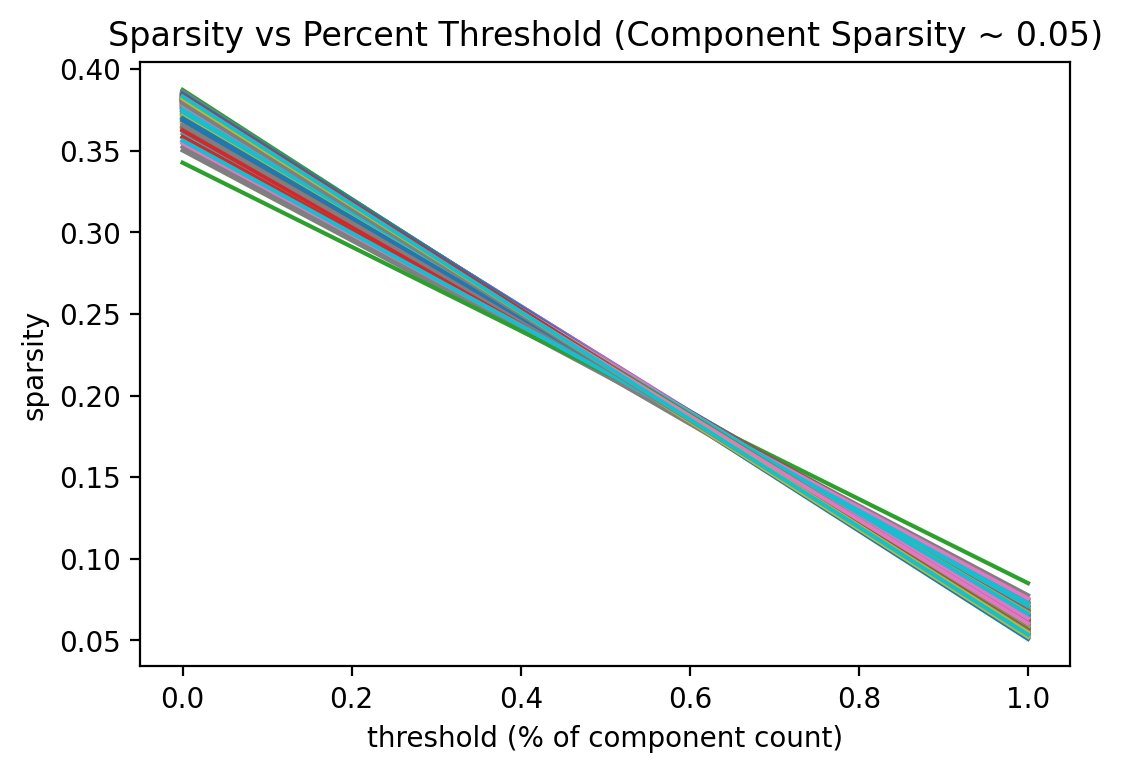

In [45]:
figure(figsize=(6,4), dpi=200)
plot_sparsity_vs_encoding_threshold(encoder=encoder, test_class_rows=test_class_rows, interval=[0, 1])

#FINDINGS:
# DIM Sparsity     Percent Range     Average ENC_THR
# 10k   0.3         11.2 - 11.6            70 @M=10
#       0.1         2.5 - 2.9              16 @M=10
#       0.1         1.8 - 1.9              10 @M=100
#       0.05         2  - 2.5              5 @M=30
#       0.05         1 - 1.5               7 @M=10
#       0.05         2.2 - 2.8             15 @M=2

#IM and ENCODED DIFF SPARSITIES
# DIM IM_Sparsity   Target_Sparsity  Percent Range     Average ENC_THR
# 10k    0.05           0.02            1.6-1.8             (9,0.17)

Mean number of ones: 891.2730769230769


C:\Users\ACER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

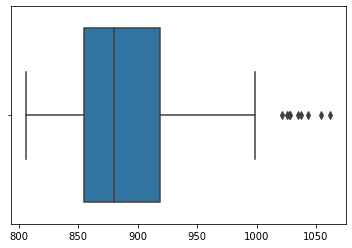

In [49]:
no_of_ones = []
encoder = setup_feature_encoder(dim=10000, sparsity=0.05, percent_max_val=5/617, M=10)
for class_ in classes:
    for row in test_class_rows[class_]:
        no_of_ones.append( np.sum(encoder.encode(row)) )

print("Mean number of ones: {}".format(np.average(np.array(no_of_ones))))
sns.boxplot(no_of_ones)